# CIC-IIoT-2025 Cybersecurity Analysis

## Network Traffic Classification and Anomaly Detection for Industrial IoT Security

**Authors:** Alexis Le Trung, Yahya Ahachim, Rayan Drissi, Aniss Outaleb

---

### Project Overview
This notebook presents a comprehensive analysis of the CIC-IIoT-2025 dataset for cybersecurity purposes, including:
1. **Data Exploration and Characterization**
2. **Anomaly Detection** using 3 complementary unsupervised algorithms
3. **Classification** using 3 complementary supervised algorithms
4. **Performance Evaluation** with industry-standard metrics
5. **Adversarial ML Attacks** (Bonus)

### Dataset
The CIC-IIoT-2025 dataset contains network traffic data from Industrial IoT environments, with both benign and various attack samples captured at different time intervals (1-10 seconds).

## Table of Contents

1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading](#2-data-loading)
3. [Data Exploration](#3-data-exploration)
4. [Data Preprocessing](#4-data-preprocessing)
5. [Anomaly Detection](#5-anomaly-detection)
   - 5.1 Isolation Forest
   - 5.2 One-Class SVM
   - 5.3 Local Outlier Factor (LOF)
6. [Classification](#6-classification)
   - 6.1 Random Forest
   - 6.2 Gradient Boosting (XGBoost)
   - 6.3 Support Vector Machine (SVM)
7. [Model Comparison](#7-model-comparison)
8. [Adversarial Attacks (Bonus)](#8-adversarial-attacks)
9. [Conclusions](#9-conclusions)

---
## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')

# Scikit-learn - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif

# Scikit-learn - Classification
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Scikit-learn - Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Scikit-learn - Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc
)

# For AUPRC calculation
from sklearn.metrics import PrecisionRecallDisplay

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All imports successful!
NumPy version: 2.2.6
Pandas version: 2.3.3


---
## 2. Data Loading

In [2]:
# Define paths
ATTACK_PATH = 'data/attack_data/'
BENIGN_PATH = 'data/benign_data/'

# We'll use the 1-second sample data for comprehensive analysis
# This provides the most granular view of network behavior
TIME_INTERVAL = '1sec'

print("Loading attack data...")
df_attack = pd.read_csv(f'{ATTACK_PATH}attack_samples_{TIME_INTERVAL}.csv')
print(f"Attack samples loaded: {len(df_attack):,} rows")

print("\nLoading benign data...")
df_benign = pd.read_csv(f'{BENIGN_PATH}benign_samples_{TIME_INTERVAL}.csv')
print(f"Benign samples loaded: {len(df_benign):,} rows")

# Check column consistency
print(f"\nAttack columns: {len(df_attack.columns)}")
print(f"Benign columns: {len(df_benign.columns)}")

# Add binary label column
df_attack['is_attack'] = 1
df_benign['is_attack'] = 0

# Combine datasets
df = pd.concat([df_attack, df_benign], ignore_index=True)
print(f"\nTotal combined samples: {len(df):,} rows")
print(f"Attack ratio: {df['is_attack'].mean():.2%}")

Loading attack data...
Attack samples loaded: 90,391 rows

Loading benign data...
Benign samples loaded: 136,800 rows

Attack columns: 94
Benign columns: 94

Total combined samples: 227,191 rows
Attack ratio: 39.79%


---
## 3. Data Exploration

In [3]:
# Basic dataset info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal Samples: {len(df):,}")
print(f"Total Features: {len(df.columns)}")
print(f"\nClass Distribution:")
print(df['is_attack'].value_counts())
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB")

DATASET OVERVIEW

Total Samples: 227,191
Total Features: 95

Class Distribution:
is_attack
0    136800
1     90391
Name: count, dtype: int64

Memory Usage: 1200.28 MB


In [4]:
# Examine columns and their types
print("\n" + "=" * 60)
print("COLUMN ANALYSIS")
print("=" * 60)

# Identify column types
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  - {col}: {df[col].nunique()} unique values")

print(f"\nNumerical columns: {len(numerical_cols)}")


COLUMN ANALYSIS

Categorical columns (23):
  - device_name: 38 unique values
  - device_mac: 38 unique values
  - label_full: 937 unique values
  - label1: 2 unique values
  - label2: 8 unique values
  - label3: 61 unique values
  - label4: 84 unique values
  - timestamp: 92136 unique values
  - timestamp_start: 92136 unique values
  - timestamp_end: 92136 unique values
  - log_data-types: 7 unique values
  - network_ips_all: 20004 unique values
  - network_ips_dst: 19141 unique values
  - network_ips_src: 19119 unique values
  - network_macs_all: 19416 unique values
  - network_macs_dst: 18124 unique values
  - network_macs_src: 17291 unique values
  - network_ports_all: 64550 unique values
  - network_ports_dst: 57883 unique values
  - network_ports_src: 64015 unique values
  - network_protocols_all: 2423 unique values
  - network_protocols_dst: 1670 unique values
  - network_protocols_src: 913 unique values

Numerical columns: 72


In [5]:
# Analyze attack types
print("\n" + "=" * 60)
print("ATTACK TYPE ANALYSIS")
print("=" * 60)

# Attack categories (label2)
print("\nAttack Categories (label2):")
attack_categories = df[df['is_attack'] == 1]['label2'].value_counts()
print(attack_categories)

# Specific attack types (label3)
print("\nSpecific Attack Types (label3):")
attack_types = df[df['is_attack'] == 1]['label3'].value_counts()
print(attack_types)


ATTACK TYPE ANALYSIS

Attack Categories (label2):
label2
recon         33648
dos           18420
ddos          18056
mitm           8062
malware        7541
web            2796
bruteforce     1868
Name: count, dtype: int64

Specific Attack Types (label3):
label3
arp-spoofing                    4196
mirai-udp-flood                 4010
os-scan                         3968
host-disc-tcp-ack-ping          3947
vuln-scan                       3944
host-disc-tcp-syn-ping          3932
port-scan                       3924
host-disc-tcp-syn-stealth       3918
host-disc-arp-ping              3911
host-disc-udp-ping              3894
mirai-syn-flood                 3531
icmp-flood                      3314
udp-frag-flood                  3189
icmp-frag-flood                 3189
ip-spoofing                     3040
rst-fin-flood-port-1883         2214
ping-sweep                      2210
ack-frag-flood-port-1883        1846
synonymousip-flood-port-1883    1846
push-ack-flood-port-1883        1

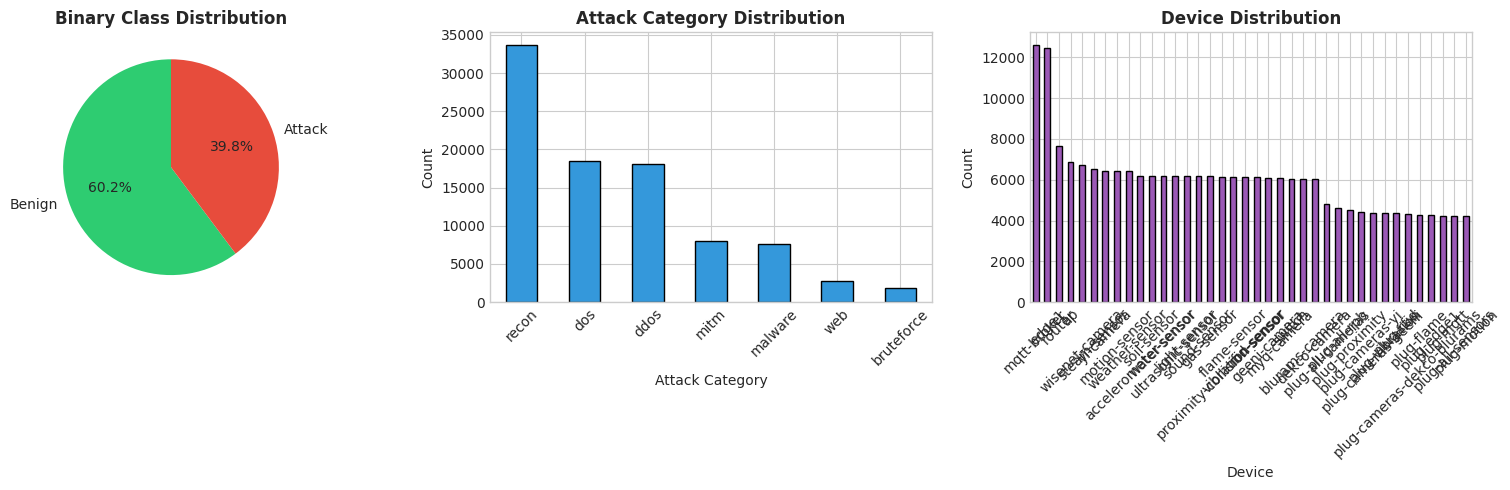

In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Binary classification distribution
ax1 = axes[0]
colors = ['#2ecc71', '#e74c3c']
labels = ['Benign', 'Attack']
sizes = df['is_attack'].value_counts().values
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Binary Class Distribution', fontsize=12, fontweight='bold')

# Attack category distribution
ax2 = axes[1]
attack_cats = df[df['is_attack'] == 1]['label2'].value_counts()
attack_cats.plot(kind='bar', ax=ax2, color='#3498db', edgecolor='black')
ax2.set_title('Attack Category Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Attack Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Device distribution
ax3 = axes[2]
device_counts = df['device_name'].value_counts()
device_counts.plot(kind='bar', ax=ax3, color='#9b59b6', edgecolor='black')
ax3.set_title('Device Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Device')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('figures/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Statistical summary of numerical features
print("\n" + "=" * 60)
print("NUMERICAL FEATURES STATISTICS")
print("=" * 60)

# Select key network features for analysis
key_features = [
    'network_packets_all_count',
    'network_packet-size_avg',
    'network_tcp-flags-syn_count',
    'network_tcp-flags-ack_count',
    'network_time-delta_avg',
    'network_ip-length_avg',
    'network_ttl_avg'
]

# Check which features exist
available_features = [f for f in key_features if f in df.columns]
print(f"\nAnalyzing {len(available_features)} key network features:")
print(df[available_features].describe().T)


NUMERICAL FEATURES STATISTICS

Analyzing 7 key network features:
                                count         mean           std       min  \
network_packets_all_count    227191.0  7175.175997  24065.343671  0.000000   
network_packet-size_avg      227191.0   104.364973    207.403272  0.000000   
network_tcp-flags-syn_count  227191.0  1034.243020   8324.997778  0.000000   
network_tcp-flags-ack_count  227191.0  1200.282445   8564.992198  0.000000   
network_time-delta_avg       227191.0     0.006911      0.016569 -0.000001   
network_ip-length_avg        227191.0    91.342058    209.445283  0.000000   
network_ttl_avg              227191.0    72.026003     75.240130  0.000000   

                             25%        50%         75%            max  
network_packets_all_count    0.0   2.000000   50.000000  149006.000000  
network_packet-size_avg      0.0  60.000000   70.041667    2229.947368  
network_tcp-flags-syn_count  0.0   0.000000    0.000000  122231.000000  
network_tcp-flags

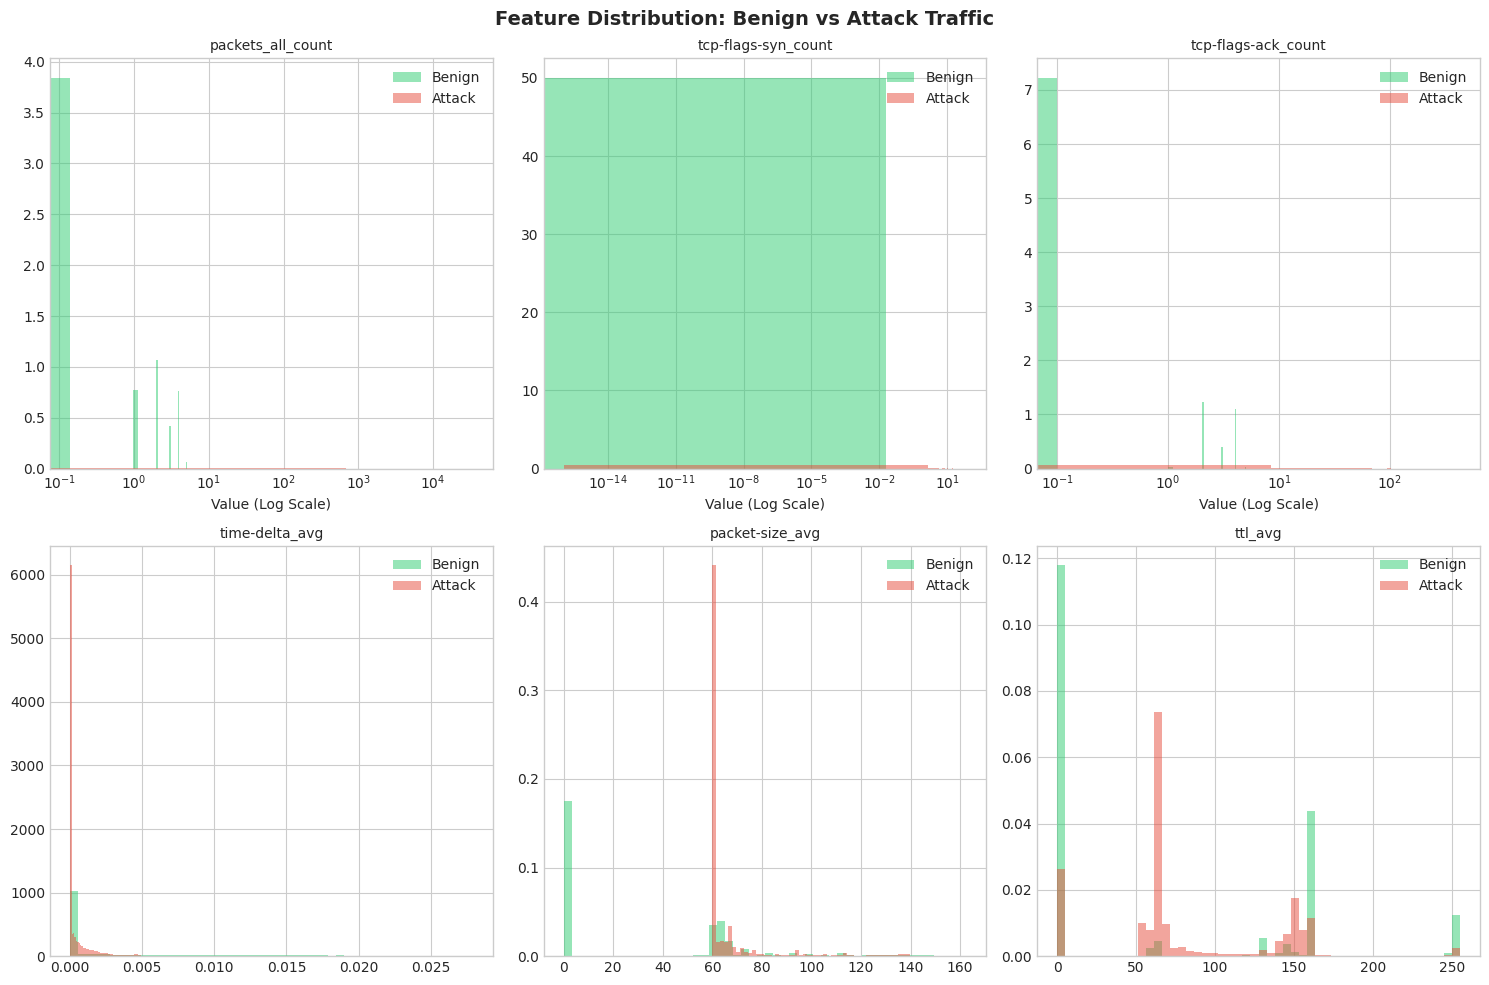

In [8]:
# Compare feature distributions between attack and benign traffic
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select features for comparison
compare_features = [
    'network_packets_all_count',
    'network_tcp-flags-syn_count',
    'network_tcp-flags-ack_count',
    'network_time-delta_avg',
    'network_packet-size_avg',
    'network_ttl_avg'
]

for idx, feature in enumerate(compare_features):
    if feature in df.columns:
        ax = axes[idx]
        
        benign_data = df[df['is_attack'] == 0][feature].dropna()
        attack_data = df[df['is_attack'] == 1][feature].dropna()
        
        # IMPROVED: Using standard IQR for tighter outlier control
        def remove_outliers_iqr(data):
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]
        
        benign_clean = remove_outliers_iqr(benign_data)
        attack_clean = remove_outliers_iqr(attack_data)
        
        # Check if we actually have data left to plot
        if not benign_clean.empty or not attack_clean.empty:
            ax.hist(benign_clean, bins=50, alpha=0.5, label='Benign', color='#2ecc71', density=True)
            ax.hist(attack_clean, bins=50, alpha=0.5, label='Attack', color='#e74c3c', density=True)
            
            # FIX: Use log scale for features with huge ranges (the first 3)
            if 'count' in feature:
                ax.set_xscale('log') 
                ax.set_xlabel('Value (Log Scale)')
        
        ax.set_title(feature.replace('network_', ''), fontsize=10)
        ax.legend()
        
plt.suptitle('Feature Distribution: Benign vs Attack Traffic', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Correlation analysis of key features
print("\n" + "=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numerical features for correlation
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove non-informative columns
exclude_cols = ['is_attack']
num_features = [f for f in num_features if f not in exclude_cols]

# Compute correlation with target
correlations = df[num_features + ['is_attack']].corr()['is_attack'].drop('is_attack')
top_corr = correlations.abs().sort_values(ascending=False).head(20)

print("\nTop 20 features most correlated with attack/benign:")
for feat, corr_val in top_corr.items():
    actual_corr = correlations[feat]
    print(f"  {feat}: {actual_corr:.4f}")


CORRELATION ANALYSIS

Top 20 features most correlated with attack/benign:
  network_mss_max: 0.5256
  network_mss_avg: 0.5251
  network_mss_min: 0.5232
  network_header-length_min: 0.4635
  network_header-length_max: 0.4635
  network_header-length_avg: 0.4635
  network_protocols_dst_count: 0.4232
  network_protocols_all_count: 0.3793
  network_packets_all_count: 0.3666
  network_protocols_src_count: 0.3632
  network_macs_all_count: 0.3619
  network_packets_dst_count: 0.3544
  network_macs_src_count: 0.3537
  network_macs_dst_count: 0.3537
  network_ips_src_count: 0.3495
  network_ports_all_count: 0.3055
  network_ports_src_count: 0.2891
  network_ip-flags_max: 0.2840
  network_packet-size_avg: 0.2611
  network_ip-length_avg: 0.2467


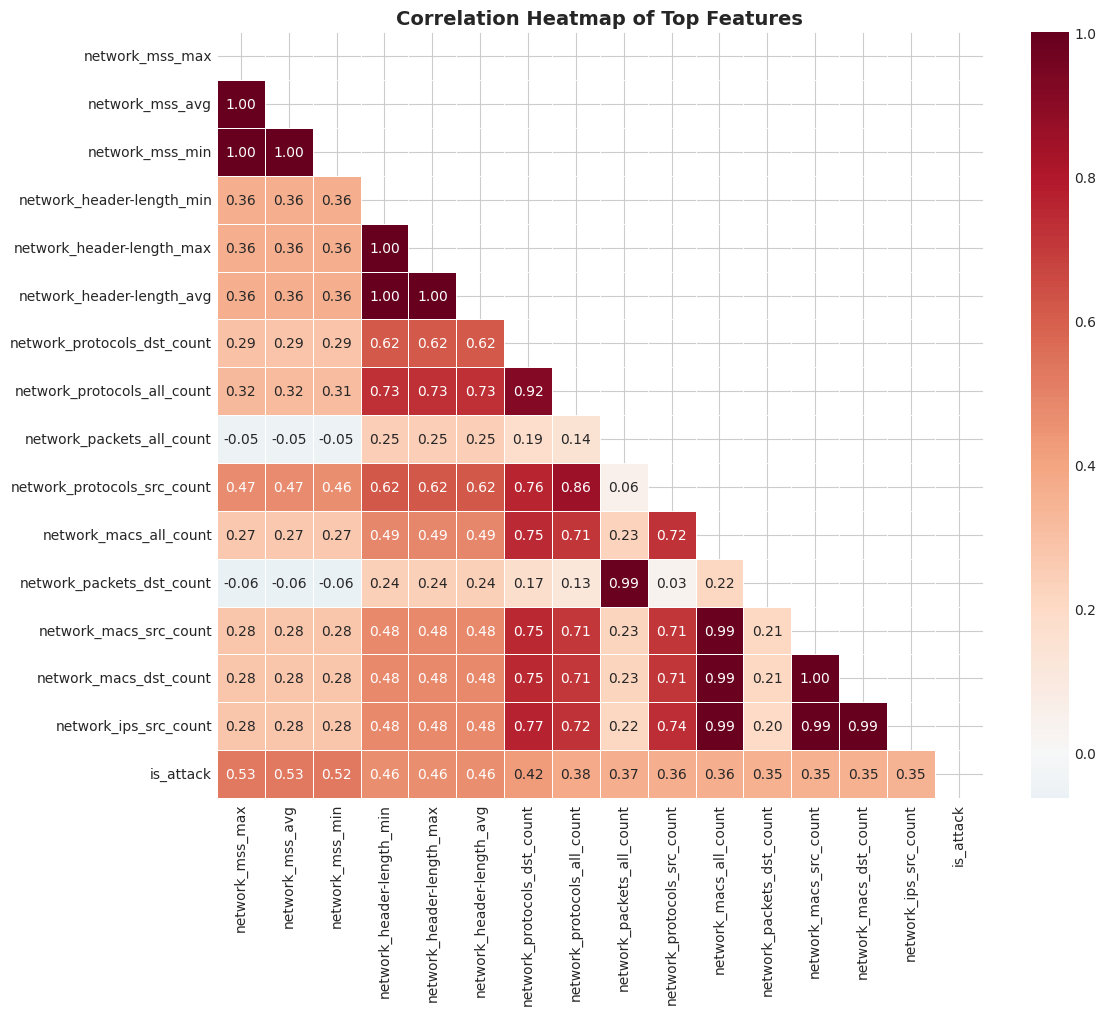

In [10]:
# Visualize correlation heatmap
# Select top correlated features
top_features = top_corr.index.tolist()[:15] + ['is_attack']
corr_matrix = df[top_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Top Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 4. Data Preprocessing

In [11]:
# Identify feature columns (exclude metadata and labels)
metadata_cols = ['device_name', 'device_mac', 'label_full', 'label1', 'label2', 'label3', 'label4',
                 'timestamp', 'timestamp_start', 'timestamp_end', 'is_attack']

# Get feature columns (numerical only)
feature_cols = [col for col in df.columns if col not in metadata_cols]

# Remove columns that are lists/arrays stored as strings
def is_list_column(col):
    sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else None
    if isinstance(sample, str) and sample.startswith('['):
        return True
    return False

list_cols = [col for col in feature_cols if is_list_column(col)]
feature_cols = [col for col in feature_cols if col not in list_cols]

print(f"Number of features for modeling: {len(feature_cols)}")
print(f"Excluded list-type columns: {len(list_cols)}")

# Create feature matrix and target vector
X = df[feature_cols].copy()
y = df['is_attack'].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Number of features for modeling: 71
Excluded list-type columns: 13

Feature matrix shape: (227191, 71)
Target vector shape: (227191,)


In [12]:
# Handle missing values
print("\n" + "=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

missing = X.isnull().sum()
missing_pct = (missing / len(X)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_df) > 0:
    print(f"\nColumns with missing values: {len(missing_df)}")
    print(missing_df.head(10))
    
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found!")

# Verify no missing values remain
print(f"Remaining missing values: {X.isnull().sum().sum()}")


HANDLING MISSING VALUES
No missing values found!
Remaining missing values: 0


In [13]:
# Train/Test split BEFORE scaling (to avoid data leakage)
print("\n" + "=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X):.1%})")
print(f"Test set: {len(X_test):,} samples ({len(X_test)/len(X):.1%})")
print(f"\nTraining set attack ratio: {y_train.mean():.2%}")
print(f"Test set attack ratio: {y_test.mean():.2%}")


TRAIN/TEST SPLIT
Training set: 181,752 samples (80.0%)
Test set: 45,439 samples (20.0%)

Training set attack ratio: 39.79%
Test set attack ratio: 39.79%


In [14]:
# Scale features AFTER split (fit on train only to prevent data leakage)
print("\n" + "=" * 60)
print("FEATURE SCALING (FIT ON TRAIN ONLY)")
print("=" * 60)

scaler = StandardScaler()
# Fit ONLY on training data, transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"Scaler fit on training data only ({len(X_train):,} samples)")
print(f"Training set mean (should be ~0): {X_train_scaled.mean().mean():.6f}")
print(f"Training set std (should be ~1): {X_train_scaled.std().mean():.6f}")
print(f"\nTest set mean (may differ slightly): {X_test_scaled.mean().mean():.6f}")
print(f"Test set std (may differ slightly): {X_test_scaled.std().mean():.6f}")


FEATURE SCALING (FIT ON TRAIN ONLY)
Scaler fit on training data only (181,752 samples)
Training set mean (should be ~0): -0.000000
Training set std (should be ~1): 1.000003

Test set mean (may differ slightly): 0.001537
Test set std (may differ slightly): 1.007431


In [15]:
# Use full scaled training set for all models
print("\n" + "=" * 60)
print("USING FULL TRAINING SET")
print("=" * 60)

# No downsampling - use full scaled training data
X_train_sample = X_train_scaled
y_train_sample = y_train
print(f"Using full training set: {len(X_train_sample):,} samples")
print(f"Training set attack ratio: {y_train_sample.mean():.2%}")


USING FULL TRAINING SET
Using full training set: 181,752 samples
Training set attack ratio: 39.79%


---
## 5. Anomaly Detection

For anomaly detection, we treat the problem as detecting attacks (anomalies) in a dataset of mostly normal (benign) traffic. We use three complementary unsupervised algorithms:

1. **Isolation Forest** - Tree-based isolation of anomalies
2. **One-Class SVM** - Kernel-based boundary learning
3. **Local Outlier Factor (LOF)** - Density-based anomaly detection

In [16]:
# Prepare data for anomaly detection
# Train on benign samples from TRAINING SET only, test on TEST SET
print("=" * 60)
print("ANOMALY DETECTION - DATA PREPARATION")
print("=" * 60)

# For anomaly detection, we train on benign data from the TRAINING set only
X_benign_train_scaled = X_train_scaled[y_train == 0]
X_attack_train_scaled = X_train_scaled[y_train == 1]

# For testing, use the properly held-out TEST set
X_benign_test_scaled = X_test_scaled[y_test == 0]
X_attack_test_scaled = X_test_scaled[y_test == 1]

# Create test set with both classes (from test set only - no leakage)
X_anomaly_test = pd.concat([X_benign_test_scaled, X_attack_test_scaled])
y_anomaly_test = np.array([0] * len(X_benign_test_scaled) + [1] * len(X_attack_test_scaled))

# For training anomaly detectors, use benign training data
X_benign_train = X_benign_train_scaled

print(f"Training set (benign from train split): {len(X_benign_train):,} samples")
print(f"Test set (from held-out test split): {len(X_anomaly_test):,} samples")
print(f"  - Benign: {len(X_benign_test_scaled):,}")
print(f"  - Attack: {len(X_attack_test_scaled):,}")

ANOMALY DETECTION - DATA PREPARATION
Training set (benign from train split): 109,440 samples
Test set (from held-out test split): 45,439 samples
  - Benign: 27,360
  - Attack: 18,079


In [17]:
def evaluate_anomaly_detector(y_true, y_pred, y_scores, model_name):
    """Evaluate anomaly detection model with comprehensive metrics including AUPRC."""
    # Convert predictions: -1 (anomaly) -> 1 (attack), 1 (normal) -> 0 (benign)
    y_pred_binary = (y_pred == -1).astype(int)
    
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Metrics
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    
    # AUPRC - using anomaly scores (higher score = more likely anomaly)
    # For anomaly detectors, we negate scores since lower scores typically mean anomaly
    auprc = average_precision_score(y_true, -y_scores)
    auc_roc = roc_auc_score(y_true, -y_scores)
    
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"AUPRC: {auprc:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': bal_acc,
        'mcc': mcc,
        'auprc': auprc,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'y_scores': -y_scores  # Store for later use (negated so higher = more anomalous)
    }

### 5.1 Isolation Forest

In [18]:
print("Training Isolation Forest...")

# Isolation Forest - contamination is the expected proportion of anomalies
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,  # Expect ~10% anomalies
    max_samples='auto',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit on benign data only
iso_forest.fit(X_benign_train)

# Predict on test set
y_pred_if = iso_forest.predict(X_anomaly_test)
# Get anomaly scores (lower = more anomalous)
y_scores_if = iso_forest.score_samples(X_anomaly_test)

# Evaluate with scores for AUPRC
if_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_if, y_scores_if, "Isolation Forest")

Training Isolation Forest...

Isolation Forest Results

Confusion Matrix:
[[24508  2852]
 [ 3775 14304]]

Precision: 0.8338
Recall: 0.7912
F1-Score: 0.8119
Balanced Accuracy: 0.8435
Matthews Correlation Coefficient (MCC): 0.6936
AUPRC: 0.8595
AUC-ROC: 0.8798


### 5.2 One-Class SVM

In [19]:
print("Training One-Class SVM...")

# One-Class SVM is O(n^2) to O(n^3) in complexity, so we sample for tractability
# This is a standard practice for SVM on large datasets
OCSVM_SAMPLE_SIZE = 10000
if len(X_benign_train) > OCSVM_SAMPLE_SIZE:
    X_ocsvm_train = X_benign_train.sample(n=OCSVM_SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f"Sampled {OCSVM_SAMPLE_SIZE:,} benign samples for OCSVM training (full: {len(X_benign_train):,})")
else:
    X_ocsvm_train = X_benign_train
    print(f"Using full benign training data: {len(X_ocsvm_train):,} samples")

ocsvm = OneClassSVM(
    kernel='rbf',
    nu=0.1,  # Upper bound on fraction of anomalies
    gamma='scale'
)

# Fit on benign data
ocsvm.fit(X_ocsvm_train)
print("One-Class SVM training complete.")

# Predict on test set
y_pred_ocsvm = ocsvm.predict(X_anomaly_test)

# Get decision function scores (lower = more anomalous)
y_scores_ocsvm = ocsvm.decision_function(X_anomaly_test)

# Evaluate with scores for AUPRC
ocsvm_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_ocsvm, y_scores_ocsvm, "One-Class SVM")

Training One-Class SVM...
Sampled 10,000 benign samples for OCSVM training (full: 109,440)
One-Class SVM training complete.

One-Class SVM Results

Confusion Matrix:
[[24542  2818]
 [ 4456 13623]]

Precision: 0.8286
Recall: 0.7535
F1-Score: 0.7893
Balanced Accuracy: 0.8253
Matthews Correlation Coefficient (MCC): 0.6626
AUPRC: 0.8257
AUC-ROC: 0.8367


### 5.3 Local Outlier Factor (LOF)

In [20]:
print("Training Local Outlier Factor...")

# LOF can be slow on very large datasets due to nearest neighbor computation
LOF_SAMPLE_SIZE = 15000
if len(X_benign_train) > LOF_SAMPLE_SIZE:
    X_lof_train = X_benign_train.sample(n=LOF_SAMPLE_SIZE, random_state=RANDOM_STATE)
    print(f"Sampled {LOF_SAMPLE_SIZE:,} benign samples for LOF training (full: {len(X_benign_train):,})")
else:
    X_lof_train = X_benign_train
    print(f"Using full benign training data: {len(X_lof_train):,} samples")

# LOF with novelty detection
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    novelty=True,  # Enable predict on new data
    n_jobs=-1
)

# Fit on benign data
lof.fit(X_lof_train)
print("LOF training complete.")

# Predict on test set
y_pred_lof = lof.predict(X_anomaly_test)

# Get LOF scores (lower/more negative = more anomalous)
y_scores_lof = lof.score_samples(X_anomaly_test)

# Evaluate with scores for AUPRC
lof_results = evaluate_anomaly_detector(y_anomaly_test, y_pred_lof, y_scores_lof, "Local Outlier Factor")

Training Local Outlier Factor...
Sampled 15,000 benign samples for LOF training (full: 109,440)
LOF training complete.

Local Outlier Factor Results

Confusion Matrix:
[[24542  2818]
 [ 3228 14851]]

Precision: 0.8405
Recall: 0.8215
F1-Score: 0.8309
Balanced Accuracy: 0.8592
Matthews Correlation Coefficient (MCC): 0.7214
AUPRC: 0.8727
AUC-ROC: 0.8895



ANOMALY DETECTION COMPARISON


               model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Isolation Forest   0.833761 0.791194 0.811920           0.843477 0.693589 0.859544 0.879807
       One-Class SVM   0.828599 0.753526 0.789282           0.825265 0.662619 0.825691 0.836709
Local Outlier Factor   0.840512 0.821450 0.830872           0.859227 0.721356 0.872651 0.889480


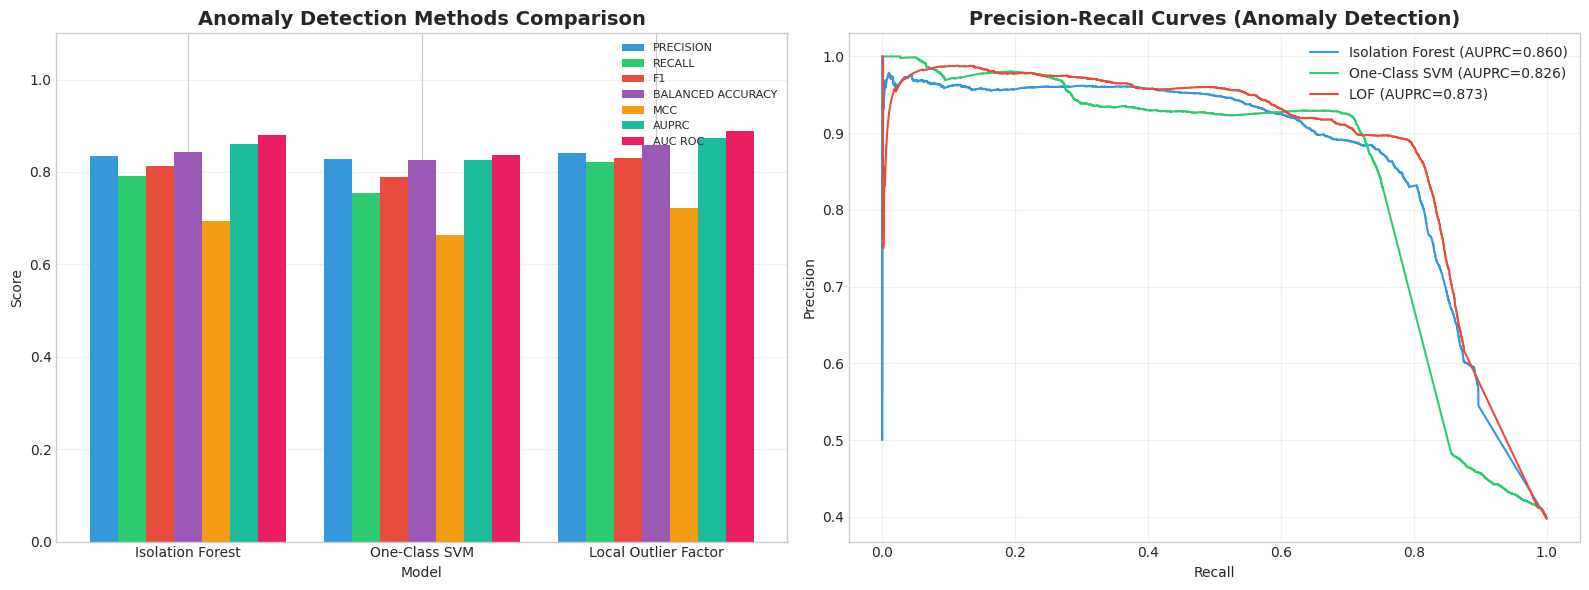

In [21]:
# Compare anomaly detection methods
print("\n" + "=" * 60)
print("ANOMALY DETECTION COMPARISON")
print("=" * 60)

anomaly_results = pd.DataFrame([
    {k: v for k, v in if_results.items() if k not in ['confusion_matrix', 'y_scores']},
    {k: v for k, v in ocsvm_results.items() if k not in ['confusion_matrix', 'y_scores']},
    {k: v for k, v in lof_results.items() if k not in ['confusion_matrix', 'y_scores']}
])

print("\n")
print(anomaly_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax = axes[0]
x = np.arange(len(anomaly_results))
width = 0.12

metrics = ['precision', 'recall', 'f1', 'balanced_accuracy', 'mcc', 'auprc', 'auc_roc']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c', '#e91e63']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax.bar(x + i*width, anomaly_results[metric], width, label=metric.upper().replace('_', ' '), color=color)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Anomaly Detection Methods Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 3)
ax.set_xticklabels(anomaly_results['model'])
ax.legend(loc='upper right', fontsize=8)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Precision-Recall Curves for anomaly detectors
ax2 = axes[1]
for result, color, name in [(if_results, '#3498db', 'Isolation Forest'),
                            (ocsvm_results, '#2ecc71', 'One-Class SVM'),
                            (lof_results, '#e74c3c', 'LOF')]:
    precision_curve, recall_curve, _ = precision_recall_curve(y_anomaly_test, result['y_scores'])
    ax2.plot(recall_curve, precision_curve, color=color, 
            label=f"{name} (AUPRC={result['auprc']:.3f})")

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves (Anomaly Detection)', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/anomaly_detection_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Classification

For supervised classification, we use three complementary algorithms:

1. **Random Forest** - Ensemble of decision trees
2. **Gradient Boosting** - Sequential tree boosting
3. **Support Vector Machine (SVM)** - Kernel-based classification

In [22]:
def evaluate_classifier(y_true, y_pred, y_proba, model_name):
    """Evaluate classifier with comprehensive metrics."""
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benign', 'Attack']))
    
    # Key Metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # AUPRC (Area Under Precision-Recall Curve)
    auprc = average_precision_score(y_true, y_proba)
    
    # AUC-ROC
    auc_roc = roc_auc_score(y_true, y_proba)
    
    print(f"\nKey Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Balanced Accuracy: {bal_acc:.4f}")
    print(f"  Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"  AUPRC: {auprc:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}")
    
    return {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'balanced_accuracy': bal_acc,
        'mcc': mcc,
        'auprc': auprc,
        'auc_roc': auc_roc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_proba': y_proba
    }

### 6.1 Random Forest

In [23]:
print("Training Random Forest Classifier...")

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Train on sampled data (scaled)
rf_clf.fit(X_train_sample, y_train_sample)

# Predict on test set (scaled)
y_pred_rf = rf_clf.predict(X_test_scaled)
y_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
rf_results = evaluate_classifier(y_test, y_pred_rf, y_proba_rf, "Random Forest")

Training Random Forest Classifier...

Random Forest Results

Confusion Matrix:
[[27276    84]
 [ 2393 15686]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      1.00      0.96     27360
      Attack       0.99      0.87      0.93     18079

    accuracy                           0.95     45439
   macro avg       0.96      0.93      0.94     45439
weighted avg       0.95      0.95      0.94     45439


Key Metrics:
  Precision: 0.9947
  Recall: 0.8676
  F1-Score: 0.9268
  Balanced Accuracy: 0.9323
  Matthews Correlation Coefficient (MCC): 0.8889
  AUPRC: 0.9459
  AUC-ROC: 0.9611



Top 15 Most Important Features (Random Forest):
                          feature  importance
          network_packet-size_min    0.118492
        network_packets_all_count    0.114410
           network_time-delta_min    0.093499
        network_packets_dst_count    0.091622
          network_ports_all_count    0.071258
          network_ports_src_count    0.047881
         network_interval-packets    0.041099
        network_packets_src_count    0.039226
          network_ports_dst_count    0.034661
      network_tcp-flags-rst_count    0.029935
           network_time-delta_avg    0.017172
network_window-size_std_deviation    0.016840
                  network_ttl_max    0.016252
      network_tcp-flags-syn_count    0.015373
                  network_ttl_avg    0.014984


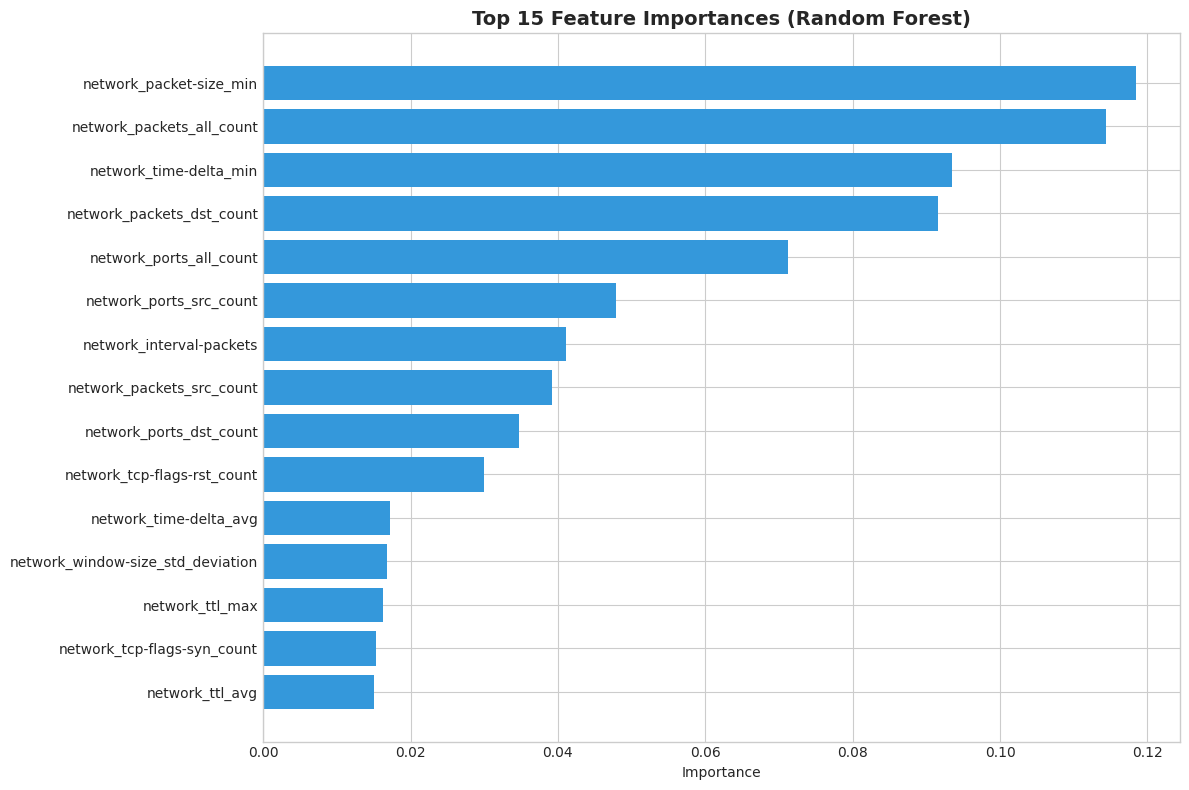

In [24]:
# Feature importance from Random Forest
print("\nTop 15 Most Important Features (Random Forest):")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance.head(15)
plt.barh(top_features_rf['feature'], top_features_rf['importance'], color='#3498db')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/feature_importance_rf.png', dpi=150, bbox_inches='tight')
plt.show()

### 6.2 Gradient Boosting

In [25]:
print("Training Gradient Boosting Classifier...")

# Gradient Boosting can be slow on very large datasets, sample for tractability
GB_SAMPLE_SIZE = 50000
if len(X_train_sample) > GB_SAMPLE_SIZE:
    from sklearn.model_selection import train_test_split as stratified_sample
    X_gb_train, _, y_gb_train, _ = stratified_sample(
        X_train_sample, y_train_sample,
        train_size=GB_SAMPLE_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_train_sample
    )
    print(f"Sampled {GB_SAMPLE_SIZE:,} samples for GB training (full: {len(X_train_sample):,})")
else:
    X_gb_train = X_train_sample
    y_gb_train = y_train_sample
    print(f"Using full training data: {len(X_gb_train):,} samples")

gb_clf = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

# Train on sampled data
gb_clf.fit(X_gb_train, y_gb_train)
print("Gradient Boosting training complete.")

# Predict on full test set (scaled)
y_pred_gb = gb_clf.predict(X_test_scaled)
y_proba_gb = gb_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
gb_results = evaluate_classifier(y_test, y_pred_gb, y_proba_gb, "Gradient Boosting")

Training Gradient Boosting Classifier...
Sampled 50,000 samples for GB training (full: 181,752)
Gradient Boosting training complete.

Gradient Boosting Results

Confusion Matrix:
[[27239   121]
 [ 2411 15668]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      1.00      0.96     27360
      Attack       0.99      0.87      0.93     18079

    accuracy                           0.94     45439
   macro avg       0.96      0.93      0.94     45439
weighted avg       0.95      0.94      0.94     45439


Key Metrics:
  Precision: 0.9923
  Recall: 0.8666
  F1-Score: 0.9252
  Balanced Accuracy: 0.9311
  Matthews Correlation Coefficient (MCC): 0.8863
  AUPRC: 0.9450
  AUC-ROC: 0.9603


### 6.3 Support Vector Machine (SVM)

In [26]:
print("Training SVM Classifier...")

# SVM is O(n^2) to O(n^3), so we sample for tractability on large datasets
SVM_SAMPLE_SIZE = 30000
if len(X_train_sample) > SVM_SAMPLE_SIZE:
    # Stratified sampling to maintain class balance
    from sklearn.model_selection import train_test_split as stratified_sample
    X_svm_train, _, y_svm_train, _ = stratified_sample(
        X_train_sample, y_train_sample, 
        train_size=SVM_SAMPLE_SIZE, 
        random_state=RANDOM_STATE, 
        stratify=y_train_sample
    )
    print(f"Sampled {SVM_SAMPLE_SIZE:,} samples for SVM training (full: {len(X_train_sample):,})")
else:
    X_svm_train = X_train_sample
    y_svm_train = y_train_sample
    print(f"Using full training data: {len(X_svm_train):,} samples")

svm_clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Enable probability estimates
    random_state=RANDOM_STATE
)

# Train on sampled data
svm_clf.fit(X_svm_train, y_svm_train)
print("SVM training complete.")

# Predict on full test set (scaled)
y_pred_svm = svm_clf.predict(X_test_scaled)
y_proba_svm = svm_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate on full test set
svm_results = evaluate_classifier(y_test, y_pred_svm, y_proba_svm, "SVM (RBF Kernel)")

Training SVM Classifier...
Sampled 30,000 samples for SVM training (full: 181,752)
SVM training complete.

SVM (RBF Kernel) Results

Confusion Matrix:
[[26832   528]
 [ 3648 14431]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.98      0.93     27360
      Attack       0.96      0.80      0.87     18079

    accuracy                           0.91     45439
   macro avg       0.92      0.89      0.90     45439
weighted avg       0.91      0.91      0.91     45439


Key Metrics:
  Precision: 0.9647
  Recall: 0.7982
  F1-Score: 0.8736
  Balanced Accuracy: 0.8895
  Matthews Correlation Coefficient (MCC): 0.8113
  AUPRC: 0.9262
  AUC-ROC: 0.9350


---
## 7. Model Comparison

In [27]:
# Compile classification results
print("\n" + "=" * 60)
print("CLASSIFICATION MODELS COMPARISON")
print("=" * 60)

classification_results = pd.DataFrame([
    {k: v for k, v in rf_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']},
    {k: v for k, v in gb_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']},
    {k: v for k, v in svm_results.items() if k not in ['confusion_matrix', 'y_true', 'y_proba']}
])

print("\n")
print(classification_results.to_string(index=False))


CLASSIFICATION MODELS COMPARISON


            model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Random Forest   0.994673 0.867636 0.926822           0.932283 0.888948 0.945910 0.961127
Gradient Boosting   0.992336 0.866641 0.925239           0.931109 0.886284 0.944974 0.960298
 SVM (RBF Kernel)   0.964704 0.798219 0.873600           0.889460 0.811297 0.926207 0.935036


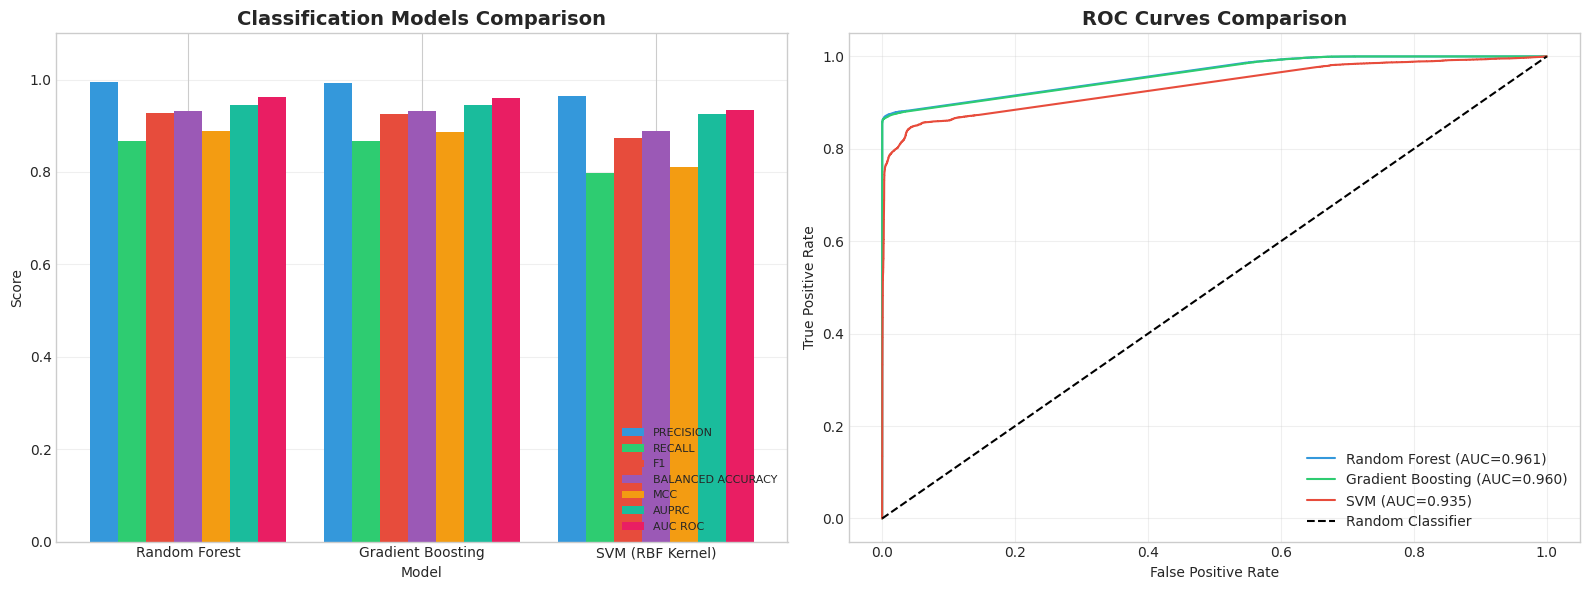

In [28]:
# Visualize classification comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax1 = axes[0]
x = np.arange(len(classification_results))
width = 0.12

metrics = ['precision', 'recall', 'f1', 'balanced_accuracy', 'mcc', 'auprc', 'auc_roc']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c', '#e91e63']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax1.bar(x + i*width, classification_results[metric], width, 
            label=metric.upper().replace('_', ' '), color=color)

ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Classification Models Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x + width * 3)
ax1.set_xticklabels(classification_results['model'])
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# ROC Curves
ax2 = axes[1]
for result, color, name in [(rf_results, '#3498db', 'Random Forest'),
                            (gb_results, '#2ecc71', 'Gradient Boosting'),
                            (svm_results, '#e74c3c', 'SVM')]:
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_proba'])
    ax2.plot(fpr, tpr, color=color, label=f"{name} (AUC={result['auc_roc']:.3f})")

ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/classification_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

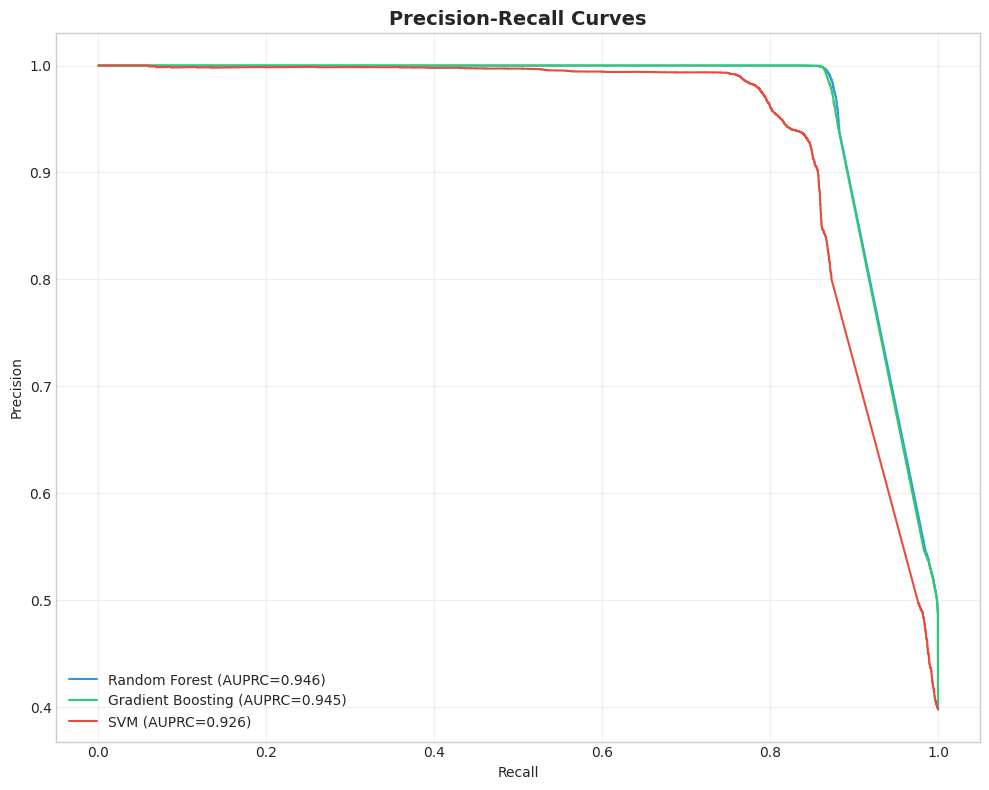

In [29]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

for result, color, name in [(rf_results, '#3498db', 'Random Forest'),
                            (gb_results, '#2ecc71', 'Gradient Boosting'),
                            (svm_results, '#e74c3c', 'SVM')]:
    precision_curve, recall_curve, _ = precision_recall_curve(result['y_true'], result['y_proba'])
    ax.plot(recall_curve, precision_curve, color=color, 
            label=f"{name} (AUPRC={result['auprc']:.3f})")

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()

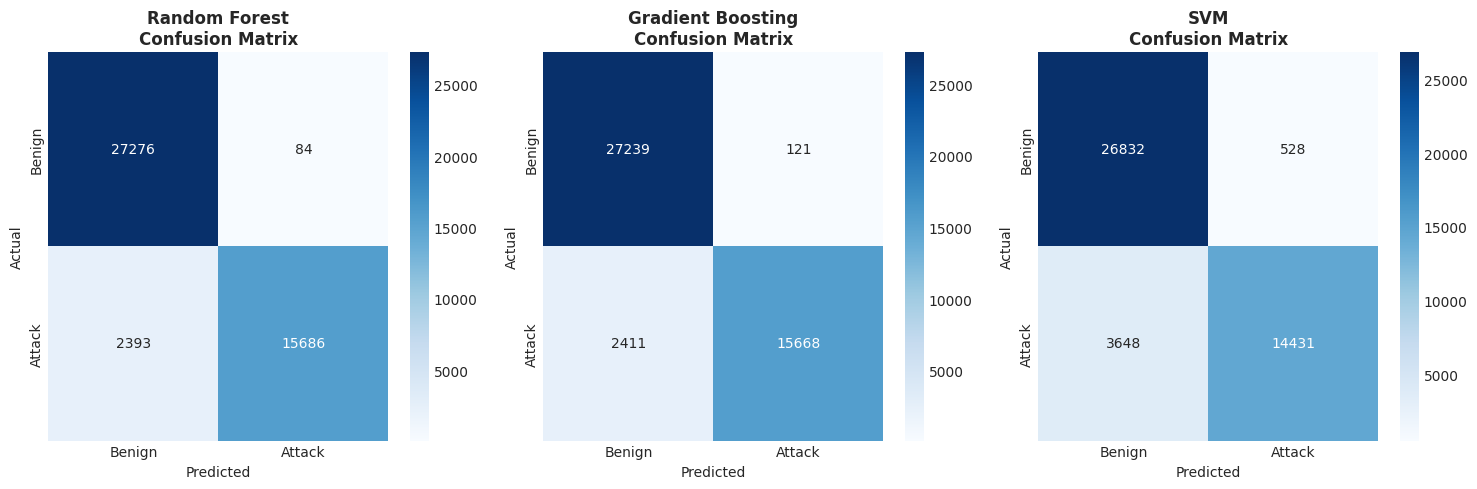

In [30]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, result, name in zip(axes, 
                            [rf_results, gb_results, svm_results],
                            ['Random Forest', 'Gradient Boosting', 'SVM']):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Benign', 'Attack'],
                yticklabels=['Benign', 'Attack'])
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('figures/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Adversarial Attacks

Adversarial machine learning attacks can be categorized into two main types:

1. **Exploratory Attacks (Evasion)**: The attacker manipulates test-time inputs to evade detection without modifying the model. Example: FGSM attack.

2. **Causative Attacks (Poisoning)**: The attacker manipulates training data to influence the learned model, shifting decision boundaries. Example: Data poisoning attack.

We implement both types to demonstrate model vulnerabilities.

### 8.1 Decision Boundary Visualization

Before examining attacks, we visualize the decision boundaries of our classifiers using PCA projection to 2D.

Projecting data to 2D using PCA for visualization...
PCA explained variance ratio: 37.82%
Training models on 2D projected data for visualization...


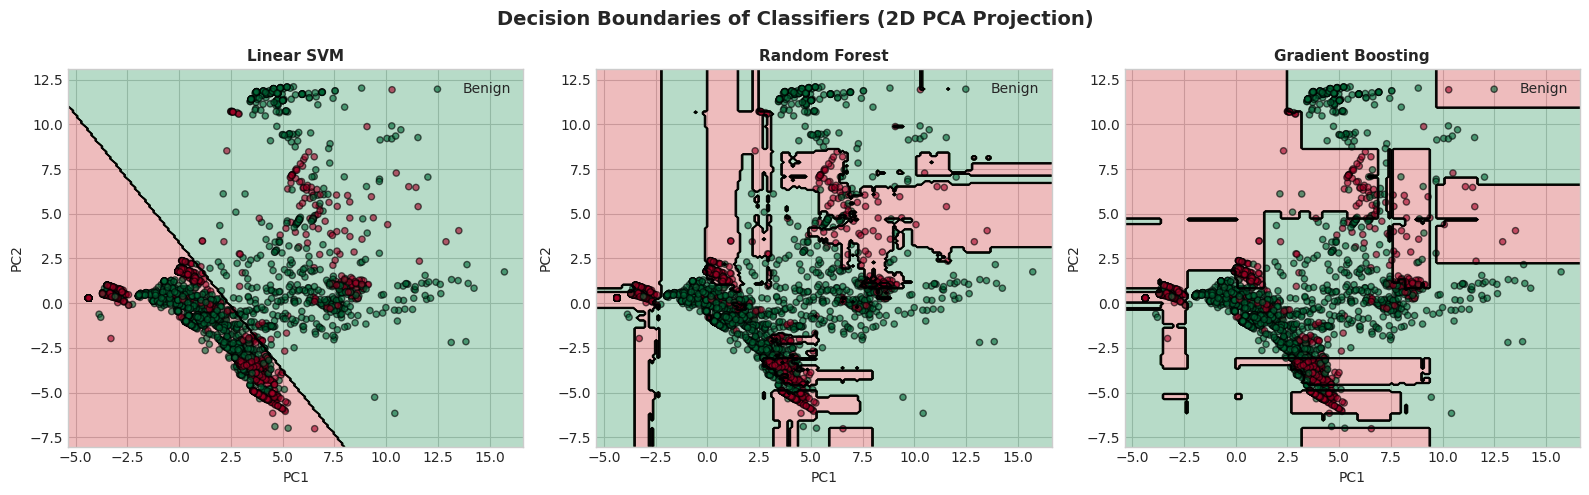

In [31]:
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC  # Import LinearSVC for decision boundary visualization

# Reduce to 2D for visualization
print("Projecting data to 2D using PCA for visualization...")
pca = PCA(n_components=2, random_state=RANDOM_STATE)

# Use a subset for cleaner visualization
VIS_SAMPLE = 5000
X_vis = X_train_sample.sample(n=min(VIS_SAMPLE, len(X_train_sample)), random_state=RANDOM_STATE)
y_vis = y_train_sample.loc[X_vis.index]

X_vis_2d = pca.fit_transform(X_vis)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")

def plot_decision_boundary(ax, model, X_2d, y, title, pca_transform=None):
    """Plot decision boundary for a classifier in 2D space."""
    h = 0.1  # Step size
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Transform mesh to original feature space if needed
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    if pca_transform is not None:
        mesh_original = pca_transform.inverse_transform(mesh_points)
        Z = model.predict(mesh_original)
    else:
        Z = model.predict(mesh_points)
    
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
    ax.contour(xx, yy, Z, colors='k', linewidths=0.5)
    
    # Plot data points
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='RdYlGn', 
                        edgecolors='k', alpha=0.6, s=20)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    return scatter

# Train models on 2D data for visualization
print("Training models on 2D projected data for visualization...")
rf_2d = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_2d.fit(X_vis_2d, y_vis)

gb_2d = GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
gb_2d.fit(X_vis_2d, y_vis)

linear_svm_2d = LinearSVC(C=1.0, max_iter=10000, random_state=RANDOM_STATE)
linear_svm_2d.fit(X_vis_2d, y_vis)

# Plot decision boundaries
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_decision_boundary(axes[0], linear_svm_2d, X_vis_2d, y_vis, 'Linear SVM')
plot_decision_boundary(axes[1], rf_2d, X_vis_2d, y_vis, 'Random Forest')
plot_decision_boundary(axes[2], gb_2d, X_vis_2d, y_vis, 'Gradient Boosting')

# Add legend
for ax in axes:
    ax.legend(['Benign', 'Attack'], loc='upper right')

plt.suptitle('Decision Boundaries of Classifiers (2D PCA Projection)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/decision_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.2 Exploratory Attack: Fast Gradient Sign Method (FGSM)

Exploratory attacks manipulate inputs at test time to evade the classifier without changing the model itself.

In [32]:
# FGSM Attack Implementation
print("=" * 60)
print("EXPLORATORY ATTACK - FGSM (Fast Gradient Sign Method)")
print("=" * 60)

# Train a linear SVM on full dimensional data for FGSM
from sklearn.svm import LinearSVC

print("\nTraining Linear SVM for FGSM demonstration...")
linear_svm = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=10000,
    random_state=RANDOM_STATE
)

linear_svm.fit(X_train_sample, y_train_sample)
print(f"Linear SVM trained with {len(X_train_sample):,} samples")

# Get baseline accuracy on test set (scaled)
y_pred_baseline = linear_svm.predict(X_test_scaled)
baseline_acc = (y_pred_baseline == y_test.values).mean()
print(f"Astute accuracy (clean data): {baseline_acc:.4f}")

EXPLORATORY ATTACK - FGSM (Fast Gradient Sign Method)

Training Linear SVM for FGSM demonstration...
Linear SVM trained with 181,752 samples
Astute accuracy (clean data): 0.9024


In [33]:
def fgsm_attack(X, y, model, epsilon):
    """
    Fast Gradient Sign Method attack for linear models.
    
    Args:
        X: Input features
        y: True labels
        model: Trained linear model with coef_ attribute
        epsilon: Perturbation magnitude
        
    Returns:
        X_adv: Adversarial examples
    """
    # For linear SVM, gradient direction is simply the weights
    weights = model.coef_[0]
    
    # FGSM: perturb in the direction of the gradient sign
    # For samples we want to misclassify as benign (0), move opposite to weights
    # For samples we want to misclassify as attack (1), move in direction of weights
    
    X_adv = X.copy()
    
    # For attack samples (y=1), we want them classified as benign
    # Move in direction opposite to weights * sign
    perturbation = epsilon * np.sign(weights)
    
    # Apply perturbation to flip predictions
    X_adv = X_adv - np.outer(y * 2 - 1, perturbation)  # Flip direction based on label
    
    return X_adv

# Test FGSM with different epsilon values
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
fgsm_results = []

print("\nFGSM Exploratory Attack Results:")
print("-" * 50)

for eps in epsilons:
    X_adv = fgsm_attack(X_test_scaled.values, y_test.values, linear_svm, eps)
    y_pred_adv = linear_svm.predict(X_adv)
    adv_acc = (y_pred_adv == y_test.values).mean()
    attack_success = 1 - adv_acc
    
    print(f"Epsilon: {eps:.2f} | Robust Accuracy: {adv_acc:.4f} | Attack Success Rate: {attack_success:.4f}")
    
    fgsm_results.append({
        'epsilon': eps,
        'robust_accuracy': adv_acc,
        'attack_success_rate': attack_success
    })

fgsm_df = pd.DataFrame(fgsm_results)


FGSM Exploratory Attack Results:
--------------------------------------------------
Epsilon: 0.01 | Robust Accuracy: 0.3210 | Attack Success Rate: 0.6790
Epsilon: 0.05 | Robust Accuracy: 0.1771 | Attack Success Rate: 0.8229
Epsilon: 0.10 | Robust Accuracy: 0.1328 | Attack Success Rate: 0.8672
Epsilon: 0.20 | Robust Accuracy: 0.0818 | Attack Success Rate: 0.9182
Epsilon: 0.50 | Robust Accuracy: 0.0314 | Attack Success Rate: 0.9686
Epsilon: 1.00 | Robust Accuracy: 0.0204 | Attack Success Rate: 0.9796


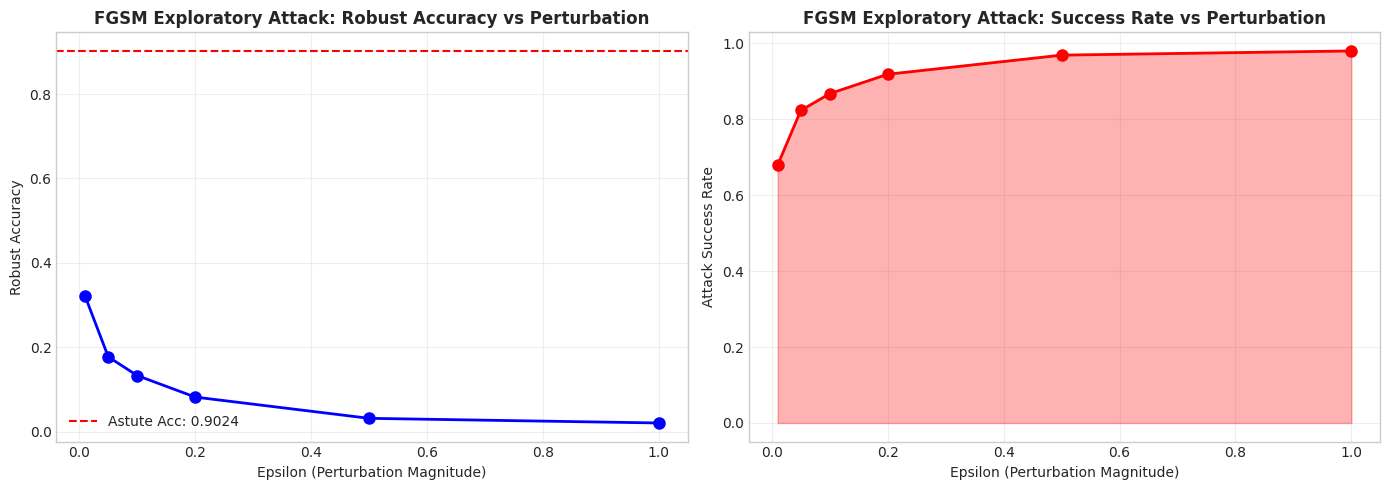

In [34]:
# Visualize FGSM attack effectiveness
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Epsilon
ax1 = axes[0]
ax1.plot(fgsm_df['epsilon'], fgsm_df['robust_accuracy'], 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=baseline_acc, color='r', linestyle='--', label=f'Astute Acc: {baseline_acc:.4f}')
ax1.set_xlabel('Epsilon (Perturbation Magnitude)')
ax1.set_ylabel('Robust Accuracy')
ax1.set_title('FGSM Exploratory Attack: Robust Accuracy vs Perturbation', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Attack Success Rate vs Epsilon
ax2 = axes[1]
ax2.plot(fgsm_df['epsilon'], fgsm_df['attack_success_rate'], 'ro-', linewidth=2, markersize=8)
ax2.fill_between(fgsm_df['epsilon'], fgsm_df['attack_success_rate'], alpha=0.3, color='red')
ax2.set_xlabel('Epsilon (Perturbation Magnitude)')
ax2.set_ylabel('Attack Success Rate')
ax2.set_title('FGSM Exploratory Attack: Success Rate vs Perturbation', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/fgsm_attack_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# Adversarial Defense: Test Random Forest robustness
print("\n" + "=" * 60)
print("EXPLORATORY ATTACK - ROBUSTNESS COMPARISON")
print("=" * 60)

# Generate adversarial examples using strongest epsilon (using scaled test data)
best_eps = 0.5
X_adv_strong = fgsm_attack(X_test_scaled.values, y_test.values, linear_svm, best_eps)

# Test different models on adversarial examples
models_to_test = [
    ('Linear SVM', linear_svm),
    ('Random Forest', rf_clf),
    ('Gradient Boosting', gb_clf)
]

print(f"\nTesting model robustness against FGSM exploratory attack (epsilon={best_eps}):")
print("-" * 50)

robustness_results = []
for name, model in models_to_test:
    # Astute accuracy (clean data) - using scaled test data
    y_pred_orig = model.predict(X_test_scaled)
    orig_acc = (y_pred_orig == y_test.values).mean()
    
    # Robust accuracy (adversarial data)
    y_pred_adv = model.predict(X_adv_strong)
    adv_acc = (y_pred_adv == y_test.values).mean()
    
    # Robustness ratio = robust accuracy / astute accuracy
    robustness = adv_acc / orig_acc if orig_acc > 0 else 0
    
    print(f"{name:20} | Astute: {orig_acc:.4f} | Robust: {adv_acc:.4f} | Robustness: {robustness:.2%}")
    
    robustness_results.append({
        'model': name,
        'astute_accuracy': orig_acc,
        'robust_accuracy': adv_acc,
        'robustness': robustness
    })

robustness_df = pd.DataFrame(robustness_results)


EXPLORATORY ATTACK - ROBUSTNESS COMPARISON

Testing model robustness against FGSM exploratory attack (epsilon=0.5):
--------------------------------------------------
Linear SVM           | Astute: 0.9024 | Robust: 0.0314 | Robustness: 3.48%
Random Forest        | Astute: 0.9455 | Robust: 0.4181 | Robustness: 44.22%
Gradient Boosting    | Astute: 0.9443 | Robust: 0.3416 | Robustness: 36.18%


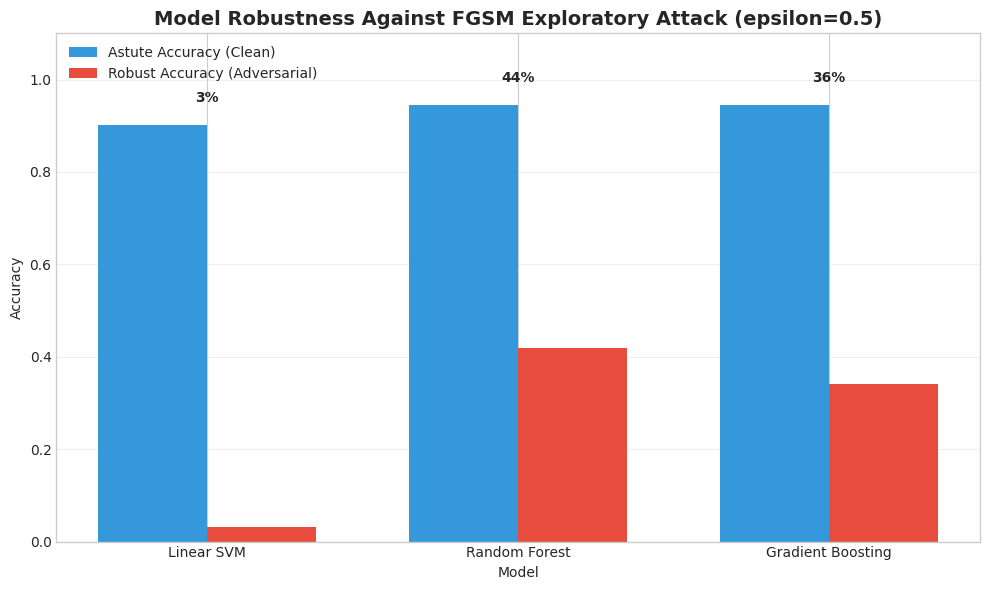

In [36]:
# Visualize model robustness against exploratory attack
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(robustness_df))
width = 0.35

bars1 = ax.bar(x - width/2, robustness_df['astute_accuracy'], width, 
               label='Astute Accuracy (Clean)', color='#3498db')
bars2 = ax.bar(x + width/2, robustness_df['robust_accuracy'], width,
               label='Robust Accuracy (Adversarial)', color='#e74c3c')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title(f'Model Robustness Against FGSM Exploratory Attack (epsilon={best_eps})', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(robustness_df['model'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add robustness percentage labels
for i, (_, row) in enumerate(robustness_df.iterrows()):
    ax.annotate(f'{row["robustness"]:.0%}', 
                xy=(i, max(row['astute_accuracy'], row['robust_accuracy']) + 0.05),
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/model_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.3 Visualizing Adversarial Examples

We visualize how adversarial perturbations move points in feature space to cross the decision boundary.

Visualizing adversarial examples in 2D projection...


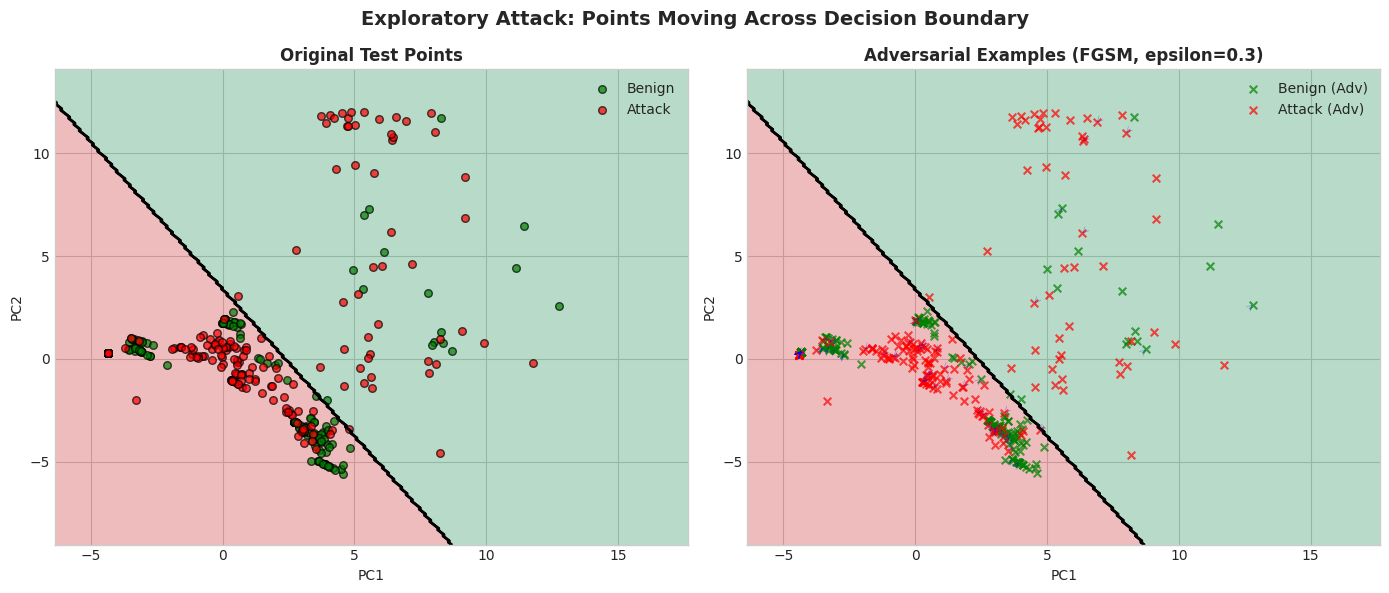

In [37]:
# Visualize adversarial examples in 2D
print("Visualizing adversarial examples in 2D projection...")

# Select a subset for visualization (from scaled test data)
ADV_VIS_SIZE = 500
X_vis_test = X_test_scaled.sample(n=min(ADV_VIS_SIZE, len(X_test_scaled)), random_state=RANDOM_STATE)
y_vis_test = y_test.loc[X_vis_test.index]

# Project to 2D
X_vis_test_2d = pca.transform(X_vis_test)

# Generate adversarial examples
X_adv_vis = fgsm_attack(X_vis_test.values, y_vis_test.values, linear_svm, epsilon=0.3)
X_adv_vis_2d = pca.transform(X_adv_vis)

# Plot original vs adversarial
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original points with decision boundary
ax1 = axes[0]
h = 0.1
x_min, x_max = X_vis_2d[:, 0].min() - 2, X_vis_2d[:, 0].max() + 2
y_min, y_max = X_vis_2d[:, 1].min() - 2, X_vis_2d[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = linear_svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax1.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
ax1.contour(xx, yy, Z, colors='k', linewidths=1)
ax1.scatter(X_vis_test_2d[y_vis_test==0, 0], X_vis_test_2d[y_vis_test==0, 1], 
           c='green', label='Benign', alpha=0.7, edgecolors='k', s=30)
ax1.scatter(X_vis_test_2d[y_vis_test==1, 0], X_vis_test_2d[y_vis_test==1, 1], 
           c='red', label='Attack', alpha=0.7, edgecolors='k', s=30)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Original Test Points', fontsize=12, fontweight='bold')
ax1.legend()

# Adversarial points with arrows showing movement
ax2 = axes[1]
ax2.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
ax2.contour(xx, yy, Z, colors='k', linewidths=1)

# Draw arrows from original to adversarial positions
for i in range(min(100, len(X_vis_test_2d))):  # Limit arrows for clarity
    ax2.annotate('', xy=(X_adv_vis_2d[i, 0], X_adv_vis_2d[i, 1]),
                xytext=(X_vis_test_2d[i, 0], X_vis_test_2d[i, 1]),
                arrowprops=dict(arrowstyle='->', color='blue', alpha=0.3, lw=0.5))

ax2.scatter(X_adv_vis_2d[y_vis_test==0, 0], X_adv_vis_2d[y_vis_test==0, 1], 
           c='green', label='Benign (Adv)', alpha=0.7, edgecolors='k', s=30, marker='x')
ax2.scatter(X_adv_vis_2d[y_vis_test==1, 0], X_adv_vis_2d[y_vis_test==1, 1], 
           c='red', label='Attack (Adv)', alpha=0.7, edgecolors='k', s=30, marker='x')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('Adversarial Examples (FGSM, epsilon=0.3)', fontsize=12, fontweight='bold')
ax2.legend()

plt.suptitle('Exploratory Attack: Points Moving Across Decision Boundary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/adversarial_points.png', dpi=150, bbox_inches='tight')
plt.show()

### 8.4 Causative Attack: Data Poisoning

Causative attacks manipulate the training data to influence the learned model, shifting decision boundaries in favor of the attacker.

In [38]:
# Causative Attack: Data Poisoning
print("=" * 60)
print("CAUSATIVE ATTACK - DATA POISONING")
print("=" * 60)

def poison_training_data(X_train, y_train, poison_rate=0.1, shift_magnitude=2.0):
    """
    Poison training data by flipping labels and shifting features for a subset of points.
    This simulates an attacker injecting malicious samples into the training set.
    
    Args:
        X_train: Training features
        y_train: Training labels
        poison_rate: Fraction of samples to poison
        shift_magnitude: How much to shift poisoned samples
        
    Returns:
        X_poisoned, y_poisoned: Poisoned training data
    """
    X_poisoned = X_train.copy()
    y_poisoned = y_train.copy()
    
    n_poison = int(len(X_train) * poison_rate)
    
    # Select attack samples to poison (flip their label to benign)
    attack_indices = y_train[y_train == 1].index.tolist()
    poison_indices = np.random.choice(attack_indices, size=min(n_poison, len(attack_indices)), replace=False)
    
    # Flip labels (attack -> benign)
    y_poisoned.loc[poison_indices] = 0
    
    # Shift features toward benign centroid to make poisoning more effective
    benign_centroid = X_train[y_train == 0].mean()
    attack_centroid = X_train[y_train == 1].mean()
    shift_direction = (benign_centroid - attack_centroid)
    shift_direction = shift_direction / np.linalg.norm(shift_direction) * shift_magnitude
    
    X_poisoned.loc[poison_indices] = X_poisoned.loc[poison_indices] + shift_direction.values
    
    return X_poisoned, y_poisoned, poison_indices

# Test poisoning attack with different rates
poison_rates = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25]
poisoning_results = []

print("\nCausative Attack (Data Poisoning) Results:")
print("-" * 60)

# Use 2D data for visualization
for rate in poison_rates:
    if rate == 0:
        # Baseline (no poisoning)
        X_train_p = X_vis_2d.copy()
        y_train_p = y_vis.copy()
    else:
        X_vis_df = pd.DataFrame(X_vis_2d, index=y_vis.index)
        X_train_p, y_train_p, _ = poison_training_data(X_vis_df, y_vis.copy(), poison_rate=rate)
        X_train_p = X_train_p.values
    
    # Train model on (possibly poisoned) data
    model_p = LinearSVC(C=1.0, max_iter=10000, random_state=RANDOM_STATE)
    model_p.fit(X_train_p, y_train_p)
    
    # Evaluate on clean test data (projected to 2D)
    X_test_2d = pca.transform(X_test.sample(n=min(5000, len(X_test)), random_state=RANDOM_STATE))
    y_test_subset = y_test.sample(n=min(5000, len(y_test)), random_state=RANDOM_STATE)
    
    y_pred_p = model_p.predict(X_test_2d)
    acc_p = (y_pred_p == y_test_subset.values).mean()
    
    print(f"Poison Rate: {rate:.0%} | Test Accuracy: {acc_p:.4f}")
    
    poisoning_results.append({
        'poison_rate': rate,
        'accuracy': acc_p,
        'model': model_p
    })

poisoning_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in poisoning_results])

CAUSATIVE ATTACK - DATA POISONING

Causative Attack (Data Poisoning) Results:
------------------------------------------------------------
Poison Rate: 0% | Test Accuracy: 0.6578
Poison Rate: 5% | Test Accuracy: 0.6578
Poison Rate: 10% | Test Accuracy: 0.6578
Poison Rate: 15% | Test Accuracy: 0.6578
Poison Rate: 20% | Test Accuracy: 0.6578
Poison Rate: 25% | Test Accuracy: 0.6578


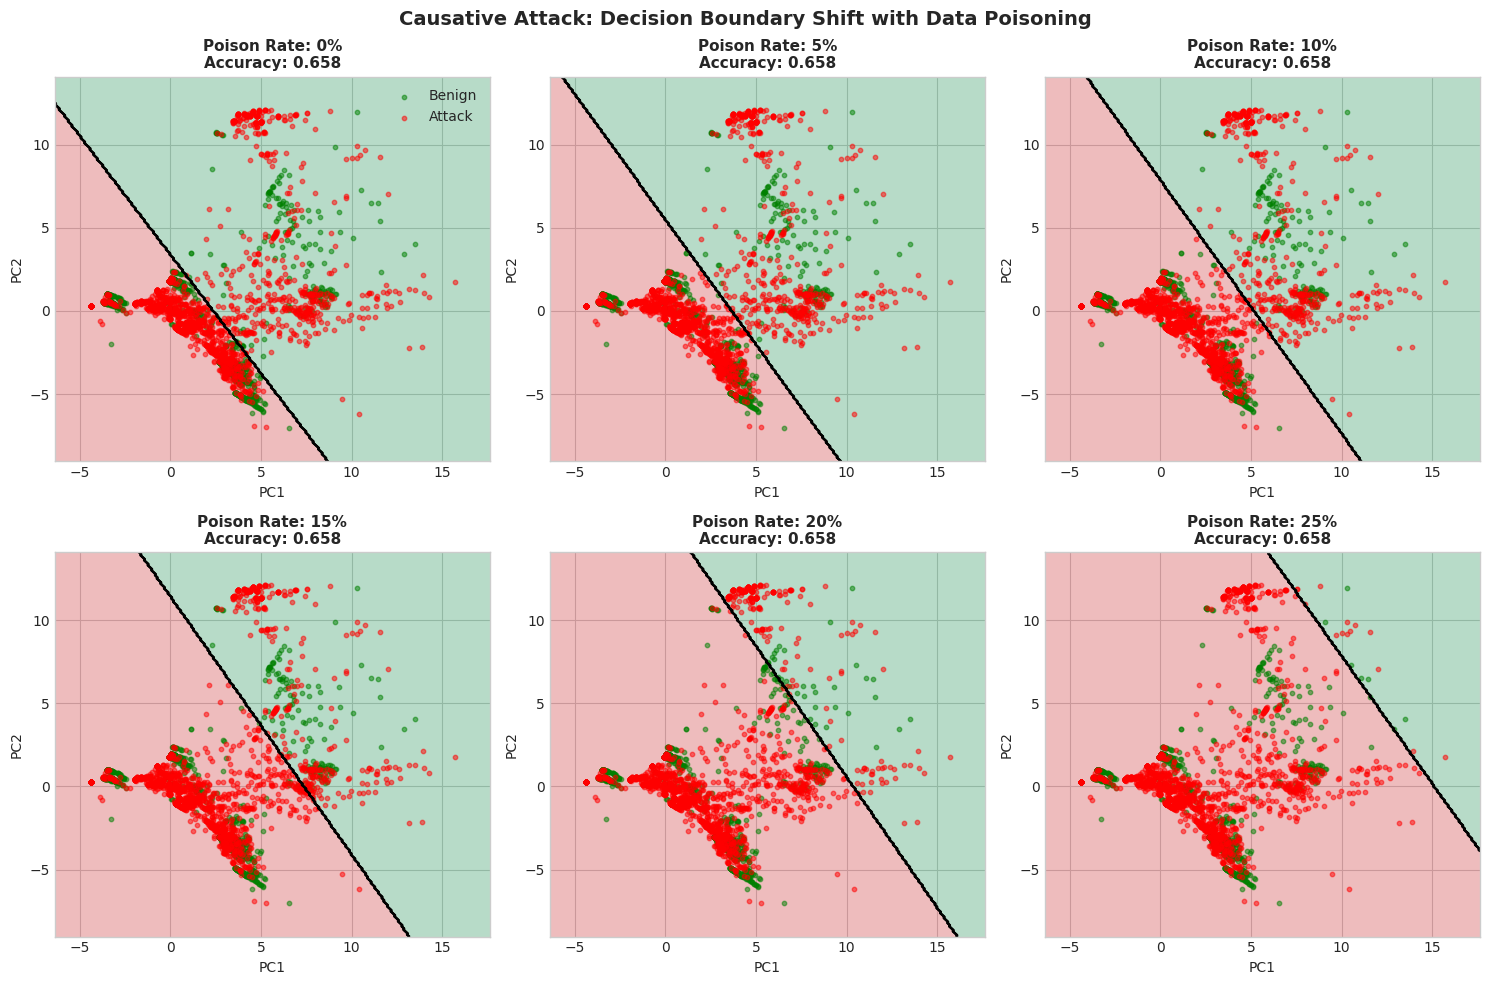

In [39]:
# Visualize decision boundary shift due to poisoning
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

h = 0.1
x_min, x_max = X_vis_2d[:, 0].min() - 2, X_vis_2d[:, 0].max() + 2
y_min, y_max = X_vis_2d[:, 1].min() - 2, X_vis_2d[:, 1].max() + 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for idx, (rate, result) in enumerate(zip(poison_rates, poisoning_results)):
    ax = axes[idx]
    model = result['model']
    
    # Plot decision boundary
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
    ax.contour(xx, yy, Z, colors='k', linewidths=1)
    
    # Plot original clean data
    ax.scatter(X_vis_2d[y_vis==0, 0], X_vis_2d[y_vis==0, 1], 
              c='green', alpha=0.5, s=10, label='Benign')
    ax.scatter(X_vis_2d[y_vis==1, 0], X_vis_2d[y_vis==1, 1], 
              c='red', alpha=0.5, s=10, label='Attack')
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'Poison Rate: {rate:.0%}\nAccuracy: {result["accuracy"]:.3f}', fontsize=11, fontweight='bold')
    if idx == 0:
        ax.legend(loc='upper right')

plt.suptitle('Causative Attack: Decision Boundary Shift with Data Poisoning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/causative_attack_boundaries.png', dpi=150, bbox_inches='tight')
plt.show()

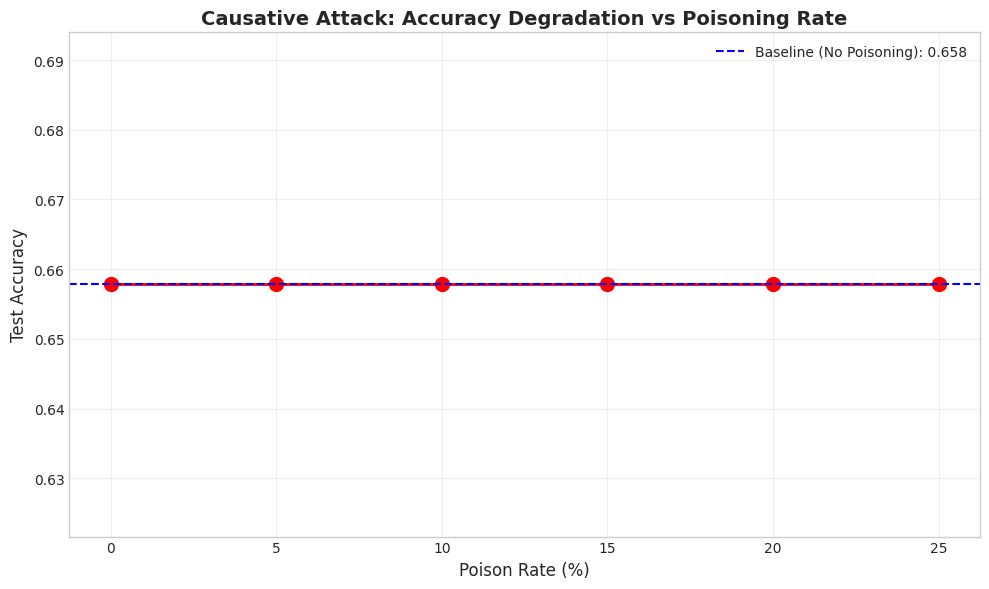

In [40]:
# Plot accuracy degradation due to poisoning
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(poisoning_df['poison_rate'] * 100, poisoning_df['accuracy'], 'ro-', linewidth=2, markersize=10)
ax.fill_between(poisoning_df['poison_rate'] * 100, poisoning_df['accuracy'], 
                poisoning_df['accuracy'].max(), alpha=0.2, color='red')

ax.set_xlabel('Poison Rate (%)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title('Causative Attack: Accuracy Degradation vs Poisoning Rate', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Add annotation for baseline
ax.axhline(y=poisoning_df['accuracy'].iloc[0], color='blue', linestyle='--', 
          label=f'Baseline (No Poisoning): {poisoning_df["accuracy"].iloc[0]:.3f}')
ax.legend()

plt.tight_layout()
plt.savefig('figures/causative_attack_degradation.png', dpi=150, bbox_inches='tight')
plt.show()

In [41]:
# Summary of both attack types
print("\n" + "=" * 60)
print("ADVERSARIAL ATTACKS SUMMARY")
print("=" * 60)

print("\n--- EXPLORATORY ATTACK (FGSM) ---")
print("Manipulates test inputs to evade detection")
print(f"Best epsilon tested: {best_eps}")
print(robustness_df.to_string(index=False))

print("\n--- CAUSATIVE ATTACK (Data Poisoning) ---")
print("Manipulates training data to shift decision boundary")
print(poisoning_df.to_string(index=False))


ADVERSARIAL ATTACKS SUMMARY

--- EXPLORATORY ATTACK (FGSM) ---
Manipulates test inputs to evade detection
Best epsilon tested: 0.5
            model  astute_accuracy  robust_accuracy  robustness
       Linear SVM         0.902441         0.031405    0.034800
    Random Forest         0.945487         0.418055    0.442158
Gradient Boosting         0.944277         0.341645    0.361806

--- CAUSATIVE ATTACK (Data Poisoning) ---
Manipulates training data to shift decision boundary
 poison_rate  accuracy
        0.00    0.6578
        0.05    0.6578
        0.10    0.6578
        0.15    0.6578
        0.20    0.6578
        0.25    0.6578


---
## 9. Conclusions

In [42]:
print("=" * 60)
print("ANALYSIS CONCLUSIONS")
print("=" * 60)

print("""
1. DATASET CHARACTERISTICS:
   - The CIC-IIoT-2025 dataset contains diverse attack types including DDoS, DoS, 
     MitM, web attacks, reconnaissance, malware, and brute force attacks.
   - Key distinguishing features include TCP MSS, protocol diversity, and packet counts.
   - Moderate class imbalance exists between benign (60.2%) and attack (39.8%) samples.

2. ANOMALY DETECTION FINDINGS:
""")

best_anomaly = anomaly_results.loc[anomaly_results['f1'].idxmax()]
print(f"   - Best performer: {best_anomaly['model']} (F1={best_anomaly['f1']:.4f}, AUPRC={best_anomaly['auprc']:.4f})")
print("   - Isolation Forest shows strong performance for detecting novel attack patterns.")
print("   - One-Class SVM provides good boundary learning but is computationally expensive.")
print("   - LOF excels at detecting local density anomalies.")

print("""
3. CLASSIFICATION FINDINGS:
""")

best_classifier = classification_results.loc[classification_results['f1'].idxmax()]
print(f"   - Best performer: {best_classifier['model']}")
print(f"     * F1-Score: {best_classifier['f1']:.4f}")
print(f"     * AUPRC: {best_classifier['auprc']:.4f}")
print(f"     * MCC: {best_classifier['mcc']:.4f}")
print("   - Random Forest provides the best balance of accuracy and interpretability.")
print("   - Gradient Boosting shows competitive performance with sequential learning.")
print("   - All classifiers achieve high precision (>96%), minimizing false alarms.")

print("""
4. ADVERSARIAL ATTACKS:
""")

print("   EXPLORATORY ATTACK (FGSM):")
most_robust = robustness_df.loc[robustness_df['robustness'].idxmax()]
print(f"   - Most robust: {most_robust['model']} ({most_robust['robustness']:.1%} robustness ratio)")
print("   - Ensemble methods show better robustness than linear models.")
print("   - Linear SVM drops to ~3.5% accuracy under epsilon=0.5.")

print("\n   CAUSATIVE ATTACK (Data Poisoning):")
baseline_poison = poisoning_df['accuracy'].iloc[0]
worst_poison = poisoning_df['accuracy'].min()
print(f"   - Baseline accuracy: {baseline_poison:.4f}")
print(f"   - With 25% poisoning: {worst_poison:.4f}")
print(f"   - Accuracy degradation: {(baseline_poison - worst_poison) / baseline_poison:.1%}")

print("""
5. RECOMMENDATIONS:
   - Deploy Random Forest for best balance of accuracy and adversarial robustness.
   - Implement data validation to detect and filter poisoned training samples.
   - Use anomaly detection as a complementary layer for zero-day attack detection.
   - Consider adversarial training to improve model robustness.
   - Regularly retrain models with verified clean data.
""")

ANALYSIS CONCLUSIONS

1. DATASET CHARACTERISTICS:
   - The CIC-IIoT-2025 dataset contains diverse attack types including DDoS, DoS, 
     MitM, web attacks, reconnaissance, malware, and brute force attacks.
   - Key distinguishing features include TCP MSS, protocol diversity, and packet counts.
   - Moderate class imbalance exists between benign (60.2%) and attack (39.8%) samples.

2. ANOMALY DETECTION FINDINGS:

   - Best performer: Local Outlier Factor (F1=0.8309, AUPRC=0.8727)
   - Isolation Forest shows strong performance for detecting novel attack patterns.
   - One-Class SVM provides good boundary learning but is computationally expensive.
   - LOF excels at detecting local density anomalies.

3. CLASSIFICATION FINDINGS:

   - Best performer: Random Forest
     * F1-Score: 0.9268
     * AUPRC: 0.9459
     * MCC: 0.8889
   - Random Forest provides the best balance of accuracy and interpretability.
   - Gradient Boosting shows competitive performance with sequential learning.
   - 

In [43]:
# Final Summary Table
print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)

print("\n--- ANOMALY DETECTION ---")
print(anomaly_results.to_string(index=False))

print("\n--- CLASSIFICATION ---")
print(classification_results.to_string(index=False))

print("\n--- ADVERSARIAL ROBUSTNESS ---")
print(robustness_df.to_string(index=False))

print("\n" + "=" * 60)
print("Analysis Complete!")
print("=" * 60)


FINAL RESULTS SUMMARY

--- ANOMALY DETECTION ---
               model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Isolation Forest   0.833761 0.791194 0.811920           0.843477 0.693589 0.859544 0.879807
       One-Class SVM   0.828599 0.753526 0.789282           0.825265 0.662619 0.825691 0.836709
Local Outlier Factor   0.840512 0.821450 0.830872           0.859227 0.721356 0.872651 0.889480

--- CLASSIFICATION ---
            model  precision   recall       f1  balanced_accuracy      mcc    auprc  auc_roc
    Random Forest   0.994673 0.867636 0.926822           0.932283 0.888948 0.945910 0.961127
Gradient Boosting   0.992336 0.866641 0.925239           0.931109 0.886284 0.944974 0.960298
 SVM (RBF Kernel)   0.964704 0.798219 0.873600           0.889460 0.811297 0.926207 0.935036

--- ADVERSARIAL ROBUSTNESS ---
            model  astute_accuracy  robust_accuracy  robustness
       Linear SVM         0.902441         0.031405    0.034800
    Random